# Reinforcement Learning for Acrobot game

Import libraries:

In [1]:
import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
% matplotlib notebook

c:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Defining hyperparameters:

Here we define all the hyperparameters for the model, this will allow as to easily iterate and find the values that give best results.

In [2]:
num_episodes = 250      # Number of episodes for training
learning_rate = 0.001
gamma = 0.99           # Discount factor for reward
num_Hidden = 100       # number of nodes in the hidden layer

env = gym.make('Acrobot-v1')    # Choose a game and create an environment
env = env.unwrapped              # The wrapper limits the number of steps in an episode, let's get rid of it
# env._max_episode_steps = 10000
obs_dim = env.reset().shape      # obervation dimension
num_actions = env.action_space.n # number of actions (this works only for descrete action space, which is the case here)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


### Define functions

**Discount reward function**: We we'll train our agent based on the reward gained for his actions. For each action we'll define the episode reward as the total reward gained in all the next steps of the current episode. Since a reward gained further away in the future has less correlation to the present action, we will give it less weight by discounting future rewards.

The formula for the discounted rewards is given by:

$$ R_t = \sum_k \gamma^k r_{t+k} $$

Where $r_t$ is the reward gained in the step $t$ and $\gamma \in [0,1]$ is a hyperparameter called the discount factor.
Here we define a function that takes a vector of rewards in consequent steps and returns the discounted reward vector:

In [3]:
def discount_rewards(r):
    '''Takes a 1D rewards (one episode) and discounts it and also standardize
    the rewards to be unit normal (helps control the gradient estimator variance)'''
    
    # Discounting
    dis_r = np.zeros_like(r)
    running_sum = 0
    for t in reversed(range(len(r))):
        running_sum = gamma*running_sum + r[t]
        dis_r[t] = running_sum
    
    # Normailzing
    dis_r = (dis_r - np.mean(dis_r))/np.std(dis_r)
        
    return dis_r

### Build model

To keep order in our model, we use name scopes which basically group the layers of our model in a simple to follow way. Eventually, when using [TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard) for visualizing the model, the graph is more readable and makes it easy to understand the model and find errors.

In [4]:
'''Create placeholders for inputs'''
# A place holder for input observations
input_ = tf.placeholder(tf.float32, shape = (None, obs_dim[0]), name = "input")
# A place holder for actions in a full episode
actions = tf.placeholder(tf.float32, shape = (None, num_actions), name = "actions")
# A place holder for discounted rewards in a full episode
dis_rewards = tf.placeholder(tf.float32, shape = (None, ), name = "dis_rewards")

'''Fully connected layers'''
with tf.name_scope("FC1"):
    fc1 = tf.layers.dense(inputs = input_, units = num_Hidden ,activation = tf.nn.relu, name = "fc1" )

with tf.name_scope("FC2"):
    fc2 = tf.layers.dense(inputs = fc1, units = num_actions ,activation = None, name = "fc2" )
    
with tf.name_scope("Action_PDF"):
    # Operate with softmax on fc2 outputs to get an action probability distribution
    action_prob_dist = tf.nn.softmax(logits = fc2, name = "softamx")

with tf.name_scope("Loss"):
    '''Define loss'''
    # Fist define reular softmax cross entropy loss
    CE_loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels = actions, logits = fc2, name = "CE_loss")
    # Modulate the loss based on our discounted reward - this is where reinforcment learning happens,
    # we favor actions that produced high reward
    loss = tf.reduce_mean(CE_loss * dis_rewards)

with tf.name_scope("Training"):
    '''Define optimizer'''
    training_opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)

'''Define saver for saving and restoring model'''
saver = tf.train.Saver()

Define a writer for saving summaries to TensorBoard:

In [5]:
# writer = tf.summary.FileWriter("./tensorboard/1/")

Here is an example of a graph visualization:

<img src="./img/model_graph.png" width="500">

Each block in the graph is expandable and let you see the content inside, for example see an [image](./img/model_graph_loss.png) with expanded loss block.

### Train model

Now that we have a model ready, we can start training it.

Our goal is to achieve a model that uses the current observation to create the best probability distribution function (PDF) for the next action to be taken. This is **not a deterministic model** - the agent has a fine probability to take any action after receiving an observation, with larger probability to take favorable actions.

To achieve that, in each step, we use our model to generate a PDF of actions, draw an action out of it and take the next step.
When we reach the end of the episode, we compute the episode loss by feeding the observation, action and discounted rewards vectors (which we kept track of). Our optimizer minimizes the loss which makes favorable (unfavorable) actions more probable (less probable) due to the multiplicative factor of the discounted reward. By repeating these steps to each episode, our agent gradually improves its PDF and becomes a better player!

In [6]:
ep_action, ep_obs, ep_reward = [], [], []  # Allocate space for episode actions, observations and rewards
tot_ep_reward = [] # Total episode reward
mean_reward = []

''' Run TF session '''
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    ''' Run episodes '''
    for ep in range(num_episodes): 
        obs = env.reset()  # Reset and save first observation
        ep_obs.append(obs) # append observation

        ''' Run steps '''
        while True:
            # Propagate forward to compute action probability distribution
            apd = np.squeeze(sess.run(action_prob_dist, feed_dict = {input_ : obs.reshape((1,obs_dim[0]))}))
            action = np.random.choice(np.arange(num_actions), p = apd)   # Sample an action based on the pdf
            obs, reward, done, info = env.step(action)  # Take action and save observation, reward and done boolean
            
            # Convert action to one hot
            action_oh = np.zeros((1,num_actions))
            action_oh[0,action] = 1
            
            ep_action.append(action_oh)  # append action
            ep_obs.append(obs)           # append observation
            ep_reward.append(reward)     # append reward

            if done: 
                # Stack vertically episode parameters to one np.array
                ep_action = np.vstack(ep_action)
                ep_obs = np.vstack(ep_obs)
                ep_reward = np.hstack(ep_reward)

                # Discount rewards
                dis_rewards_arr = discount_rewards(ep_reward)
                # Compute loss and optimize
                sess.run([loss, training_opt],
                         feed_dict = {input_ : ep_obs[:-1], actions : ep_action, dis_rewards : dis_rewards_arr})
                
                tot_ep_reward.append(np.sum(ep_reward))  # Compute total reward for episode
                mean_reward.append(np.mean(tot_ep_reward))
                
                 # print info
                print("-------------------------------------------------")
                print("Episode {}".format(ep))
                print("Episode ended after {} steps".format(ep_action.shape[0]))
                print("Accumulated reward in this episode {}".format(tot_ep_reward[ep]))
                print("Mean reward so far {:0.2f}".format(np.mean(tot_ep_reward)))
                print("Maximal reward so far {}".format(np.max(tot_ep_reward)))
                
                ep_action, ep_obs, ep_reward = [], [], []  # Clear episode values for next episode
                      
                break
                
    saver.save(sess, "models/Acrobot/model.ckpt") # save model for later
#     writer.add_graph(sess.graph) # Save graph for displaying with TensorBoard
env.close()

-------------------------------------------------
Episode 0
Episode ended after 42243 steps
Accumulated reward in this episode -42242.0
Mean reward so far -42242.00
Maximal reward so far -42242.0
-------------------------------------------------
Episode 1
Episode ended after 4189 steps
Accumulated reward in this episode -4188.0
Mean reward so far -23215.00
Maximal reward so far -4188.0
-------------------------------------------------
Episode 2
Episode ended after 1785 steps
Accumulated reward in this episode -1784.0
Mean reward so far -16071.33
Maximal reward so far -1784.0
-------------------------------------------------
Episode 3
Episode ended after 11085 steps
Accumulated reward in this episode -11084.0
Mean reward so far -14824.50
Maximal reward so far -1784.0
-------------------------------------------------
Episode 4
Episode ended after 4041 steps
Accumulated reward in this episode -4040.0
Mean reward so far -12667.60
Maximal reward so far -1784.0
------------------------------

Maximal reward so far -246.0
-------------------------------------------------
Episode 44
Episode ended after 306 steps
Accumulated reward in this episode -305.0
Mean reward so far -2601.93
Maximal reward so far -246.0
-------------------------------------------------
Episode 45
Episode ended after 284 steps
Accumulated reward in this episode -283.0
Mean reward so far -2551.52
Maximal reward so far -246.0
-------------------------------------------------
Episode 46
Episode ended after 211 steps
Accumulated reward in this episode -210.0
Mean reward so far -2501.70
Maximal reward so far -210.0
-------------------------------------------------
Episode 47
Episode ended after 248 steps
Accumulated reward in this episode -247.0
Mean reward so far -2454.73
Maximal reward so far -210.0
-------------------------------------------------
Episode 48
Episode ended after 240 steps
Accumulated reward in this episode -239.0
Mean reward so far -2409.51
Maximal reward so far -210.0
---------------------

-------------------------------------------------
Episode 87
Episode ended after 147 steps
Accumulated reward in this episode -146.0
Mean reward so far -1441.47
Maximal reward so far -137.0
-------------------------------------------------
Episode 88
Episode ended after 158 steps
Accumulated reward in this episode -157.0
Mean reward so far -1427.03
Maximal reward so far -137.0
-------------------------------------------------
Episode 89
Episode ended after 156 steps
Accumulated reward in this episode -155.0
Mean reward so far -1412.90
Maximal reward so far -137.0
-------------------------------------------------
Episode 90
Episode ended after 153 steps
Accumulated reward in this episode -152.0
Mean reward so far -1399.04
Maximal reward so far -137.0
-------------------------------------------------
Episode 91
Episode ended after 199 steps
Accumulated reward in this episode -198.0
Mean reward so far -1385.99
Maximal reward so far -137.0
-------------------------------------------------


-------------------------------------------------
Episode 131
Episode ended after 153 steps
Accumulated reward in this episode -152.0
Mean reward so far -1024.83
Maximal reward so far -135.0
-------------------------------------------------
Episode 132
Episode ended after 189 steps
Accumulated reward in this episode -188.0
Mean reward so far -1018.53
Maximal reward so far -135.0
-------------------------------------------------
Episode 133
Episode ended after 138 steps
Accumulated reward in this episode -137.0
Mean reward so far -1011.96
Maximal reward so far -135.0
-------------------------------------------------
Episode 134
Episode ended after 135 steps
Accumulated reward in this episode -134.0
Mean reward so far -1005.45
Maximal reward so far -134.0
-------------------------------------------------
Episode 135
Episode ended after 174 steps
Accumulated reward in this episode -173.0
Mean reward so far -999.33
Maximal reward so far -134.0
----------------------------------------------

-------------------------------------------------
Episode 176
Episode ended after 115 steps
Accumulated reward in this episode -114.0
Mean reward so far -806.34
Maximal reward so far -110.0
-------------------------------------------------
Episode 177
Episode ended after 147 steps
Accumulated reward in this episode -146.0
Mean reward so far -802.63
Maximal reward so far -110.0
-------------------------------------------------
Episode 178
Episode ended after 150 steps
Accumulated reward in this episode -149.0
Mean reward so far -798.98
Maximal reward so far -110.0
-------------------------------------------------
Episode 179
Episode ended after 114 steps
Accumulated reward in this episode -113.0
Mean reward so far -795.17
Maximal reward so far -110.0
-------------------------------------------------
Episode 180
Episode ended after 96 steps
Accumulated reward in this episode -95.0
Mean reward so far -791.30
Maximal reward so far -95.0
-------------------------------------------------
Epi

-------------------------------------------------
Episode 221
Episode ended after 152 steps
Accumulated reward in this episode -151.0
Mean reward so far -674.72
Maximal reward so far -95.0
-------------------------------------------------
Episode 222
Episode ended after 139 steps
Accumulated reward in this episode -138.0
Mean reward so far -672.31
Maximal reward so far -95.0
-------------------------------------------------
Episode 223
Episode ended after 185 steps
Accumulated reward in this episode -184.0
Mean reward so far -670.13
Maximal reward so far -95.0
-------------------------------------------------
Episode 224
Episode ended after 235 steps
Accumulated reward in this episode -234.0
Mean reward so far -668.20
Maximal reward so far -95.0
-------------------------------------------------
Episode 225
Episode ended after 120 steps
Accumulated reward in this episode -119.0
Mean reward so far -665.77
Maximal reward so far -95.0
-------------------------------------------------
Episo

### Assess model performance

In order to get a sense of how good our model is, and to see if our agent improves in the training process, we can plot the mean rewards gained in one episode over the episode number. This value would grow as our agent becomes more skilled and gains more rewards in each episode.

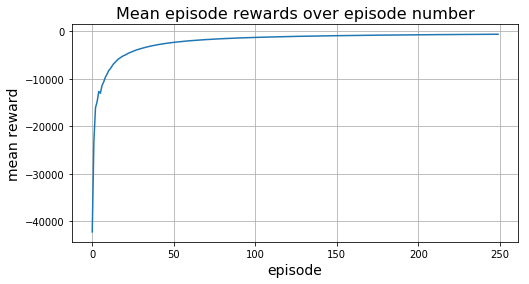

In [7]:
plt.figure(figsize=(8,4))
plt.plot(mean_reward)
plt.xlabel("episode", fontsize=14)
plt.ylabel("mean reward", fontsize = 14)
plt.title("Mean episode rewards over episode number", fontsize = 16)
plt.grid()

### Watch the agent play an episode

This is the fun part!
Now we get to see how good our agent really is by watching it play an episode.

In [8]:
ep_reward = []
env = gym.make('Acrobot-v1')
env._max_episode_steps = 1000
# env = gym.wrappers.Monitor(env, "recording/LunarLander")
with tf.Session() as sess:
    saver.restore(sess, "models/Acrobot/model.ckpt") # load model
    obs = env.reset() # Reset env and save observation
    t = 0
    while True:
        env.render() # Render game
        # Use our model to create a probability distribution of actions based on observation
        apd = np.squeeze(sess.run(action_prob_dist, feed_dict={input_ : obs.reshape((1,obs_dim[0]))}))
        # Choose an action out of the PDF and take action
        action = np.random.choice(np.arange(num_actions), p = apd)
        obs, reward, done, info = env.step(action)
        ep_reward.append(reward)
        t = t+1
        if done:
            print("Game ended after {} steps".format(t+1))
            print("Total reward earned in this episode: {:0.2f}".format(sum(ep_reward)))
            break
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from models/Acrobot/model.ckpt
Game ended after 133 steps
Total reward earned in this episode: -131.00


### Test the trained model performance

In [9]:
num_ep = 10
ep_reward = []
batch_reward = []
env = gym.make('Acrobot-v1')
env._max_episode_steps = 1000
with tf.Session() as sess:
    saver.restore(sess, "models/Acrobot/model.ckpt") # load model
    for ep in range(num_ep):
        obs = env.reset() # Reset env and save observation
        t = 0
        while True:
            # Use our model to create a probability distribution of actions based on observation
            apd = np.squeeze(sess.run(action_prob_dist, feed_dict={input_ : obs.reshape((1,obs_dim[0]))}))
            # Choose an action out of the PDF and take action
            action = np.random.choice(np.arange(num_actions), p = apd)
            obs, reward, done, info = env.step(action)
            ep_reward.append(reward)
            t = t+1
            if done:
                print("-------------------------------------------")
                print("Game ended after {} steps".format(t+1))
                print("Total reward earned in this episode: {:0.2f}".format(sum(ep_reward)))
                batch_reward.append(sum(ep_reward))
                ep_reward = []
                break
print("===================================================")
print("Average reward in batch is {:0.2f}".format(np.mean(batch_reward)))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from models/Acrobot/model.ckpt
-------------------------------------------
Game ended after 160 steps
Total reward earned in this episode: -158.00
-------------------------------------------
Game ended after 181 steps
Total reward earned in this episode: -179.00
-------------------------------------------
Game ended after 120 steps
Total reward earned in this episode: -118.00
-------------------------------------------
Game ended after 121 steps
Total reward earned in this episode: -119.00
-------------------------------------------
Game ended after 151 steps
Total reward earned in this episode: -149.00
-------------------------------------------
Game ended after 137 steps
Total reward earned in this episode: -135.00
-------------------------------------------
Game ended after 165 steps
Total reward earned in this episode: -163.00
---------------------